## EECS 126 Project

This research aims to use the Markov Chain Monte-Carlo (MCMC) sampling method to achieve super-resolution image reconstruction. The goal of super-resolution image reconstruction is to construct a higher resolution image given one, potentially blurred and slighted tweaked, with lower resolution.

This could be very useful for enhancing images or being a preliminary step for other image processing such as image recognition. Similar to Markov-chain modeled text generation, image generation can be considered as a 2-dimensional Markov random field (MRF), where each pixel is conditionally independent from all other pixels except its neighbors.

In [9]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
def read_img(path):
    """
    Read an image and output a gray scale numpy.ndarray matrix in range 0 to 1
    """
    return imageio.imread(path, as_gray=True) / 255

In [11]:
class ImageSR:
    def __init__(self,
                 width: int,
                 height: int,
                 observations: np.ndarray,
                 blurrings: np.ndarray,
                 noise_var: float,
                 inference_range: int = 2):
        """
        :param width: the desired width of the high-res image
        :param height: the desired height of the high-res image
        :param observations: the list of low-res images
        :param blurrings: the expected blurring and downsampling method for
            each observation
        :param noise_var: the expected variance of the Gaussian noise
        :param inference_range: the range that we consider as influential to a
            point. For example, if inference_range = 2, we allow pixels marked
            with an 'x' to influence the point marked with a '#':
            o o x o o
            o x x x o
            x x # x x
            o x x x o
            o o x o o
        """
        # the size of high-res vector
        self.M = width * height
        # a list of low-res vectors
        self.ys = observations
        # the size of the low-res vector
        self.L = observations[0].size
        self.hs = blurrings
        self.gamma = inference_range
        # number of low-res vectors
        self.rho = self.ys.size
        self.sigma = noise_var

        # the neighborhood matrix
        self.C = np.zeros((self.M, self.M))
        for x1 in range(height):
            for y1 in range(width):
                for x2 in range(height):
                    for y2 in range(width):
                        i = x1 * width + y1
                        j = x2 * width + y2
                        if 0 < abs(x1 - x2) + abs(y1 - y2) <= inference_range:
                            self.C[i, j] = -1
        for i in range(self.M):
            self.C[i, i] = -np.sum(self.C[i])

        # the paper said lambda is a "positive weighting parameter"
        # is this a hyperparameter that we needs to grid-search for?
        # TODO: what is lambda?
        self.lmbda = 1.0

    def gibbs(self, num_samples=1000):
        zs = np.zeros(num_samples, self.M)
        zs[0] = np.random.rand(self.M)

        for i in range(1, num_samples):
            zs[i] = np.copy(zs[i - 1])
            n = np.random.randint(1, self.M)
            zs[i, n] = self.sample(zs[i - 1], n)

        # The paper said we should take the average of the last num_samples - T samples
        # where T is the expected convergence time
        # I don't quite get it but we should take the average of the last few samples
        # instead of all them for sure
        # TODO: implement convergence time
        return np.mean(zs)

    def sample(self, z, n):
        # I think the paper means we want to sample from a Gaussian
        # TODO: is this correct?
        return np.random.normal(self.mu(z, n), np.sqrt(self.tau(z, n)))

    def psi(self, x, n, i, k):
        result = self.ys[k, i]
        for j in range(self.M):
            if j != n:
                result -= self.hs[k, i, j] * x[j]
        return result

    def phi(self, x, n):
        result = 0
        for s in range(self.M):
            result += self.C[s, n] * x[s] + self.C[n, s] * x[s]
        return result

    def tau(self, x, n):
        result = 0
        for k in range(self.rho):
            for i in range(self.M):
                result += (self.hs[k, i, n] / self.sigma) ** 2 + self.lmbda * self.C[n, n]
        return 1 / result

    def mu(self, x, n):
        result = 0
        for k in range(self.rho):
            for i in range(self.M):
                result += self.psi(x, n, i, k) * self.hs[k, i, n] / (self.sigma ** 2)
        return self.tau(x, n) / 2 * (2 * result - self.lmbda * self.phi(x, n))

In [25]:
def rgb2gray(rgb):
    """
    (For colored picture only)Convert colored picture to b/w.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

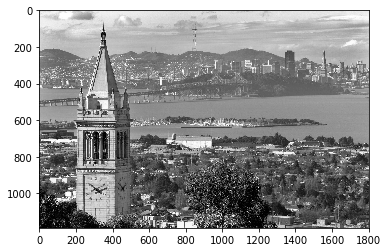

In [32]:
#test: berkeley picture
berkeley_img = rgb2gray(mpimg.imread('berkeley.jpg')) / 256.0
plt.imshow(berkeley_img, cmap = plt.get_cmap('gray'))
plt.show()

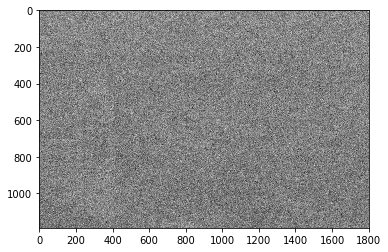

In [34]:
#test: blurred berkeley
def genereate_blured_picture(original_pic, noise_mean=0, noise_std=0., num_generation=10):
    result = []
    for _ in range(num_generation):
        rand_vector = np.random.normal(noise_mean, noise_std, original_pic.shape)
        result.append(original_pic + rand_vector)
    return result

blurred_berkeley = genereate_blured_picture(berkeley_img)
plt.imshow(blurred_berkeley[0], cmap = plt.get_cmap('gray'))
plt.show()

